In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_multigrid_adaptive'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b929fcf60> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b94aeb588>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.679    |
| time/              |          |
|    fps             | 399      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 29 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.667       |
| time/                   |             |
|    fps                  | 470         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                 

policy iteration runtime: 26 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.726      |
| time/                   |            |
|    fps                  | 483        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05085764 |
|    clip_fraction        | 0.485      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.07       |
|    explained_variance   | 0.96       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0631    |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0447    |
|    std                  | 0.181      |
|    value_loss           | 

policy iteration runtime: 26 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.744       |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.048280817 |
|    clip_fraction        | 0.506       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.37        |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0503     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0428     |
|    std                  | 

policy iteration runtime: 26 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.772       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058969725 |
|    clip_fraction        | 0.552       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.61        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000243   |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0431     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.781       |
| time/                   |             |
|    fps                  | 481         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.059190728 |
|    clip_fraction        | 0.58        |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.03        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0412     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0407     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 31 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.797      |
| time/                   |            |
|    fps                  | 484        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07169143 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.55       |
|    explained_variance   | 0.975      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0213    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0369    |
|    std                  | 0.17       |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.811      |
| time/                   |            |
|    fps                  | 461        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07091652 |
|    clip_fraction        | 0.585      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.11       |
|    explained_variance   | 0.978      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0485    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0322    |
|    std                  | 0.166      |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.817      |
| time/                   |            |
|    fps                  | 468        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07097624 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.984      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0584    |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0304    |
|    std                  | 0.159      |
|    

policy iteration runtime: 26 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.822      |
| time/                   |            |
|    fps                  | 477        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06982125 |
|    clip_fraction        | 0.596      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0563    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0245    |
|    std                  | 0.155      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 466        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09430981 |
|    clip_fraction        | 0.608      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.4       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0428    |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0217    |
|    std                  | 0.15       |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 493         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.082806155 |
|    clip_fraction        | 0.612       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.1        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0101      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0213     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b94aeb588> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b92a0cdd8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.844      |
| time/                   |            |
|    fps                  | 338        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08764621 |
|    clip_fraction        | 0.608      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0144     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0206    |
|    std                  | 0.143      |
|    value_loss           | 0.000647   |
---------------------------------

policy iteration runtime: 28 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 386        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07808529 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.026     |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.019     |
|    std                  | 0.14       |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.097272135 |
|    clip_fraction        | 0.617       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.1        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0178     |
|    n_updates            | 2080        |
|    policy_gradient_loss | -0.0198     |
|    std                  | 0.139       |
|    va

policy iteration runtime: 33 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.845       |
| time/                   |             |
|    fps                  | 383         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.100679934 |
|    clip_fraction        | 0.62        |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.4        |
|    explained_variance   | 0.983       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0654     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.0202     |
|    std                  | 0.137       |
|    va

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b92a0cdd8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b900469e8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.853      |
| time/                   |            |
|    fps                  | 223        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09047584 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.4       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0148     |
|    n_updates            | 2280       |
|    policy_gradient_loss | -0.0183    |
|    std                  | 0.137      |
|    value_loss           | 0.00101    |
---------------------------------

policy iteration runtime: 32 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.854      |
| time/                   |            |
|    fps                  | 226        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09786494 |
|    clip_fraction        | 0.632      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.6       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.015      |
|    n_updates            | 2440       |
|    policy_gradient_loss | -0.0148    |
|    std                  | 0.135      |
|    

policy iteration runtime: 37 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.854       |
| time/                   |             |
|    fps                  | 233         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.096971884 |
|    clip_fraction        | 0.628       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.9        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0139      |
|    n_updates            | 2600        |
|    policy_gradient_loss | -0.0191     |
|    std                  | 0.134       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.853       |
| time/                   |             |
|    fps                  | 230         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.096419655 |
|    clip_fraction        | 0.632       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.1        |
|    explained_variance   | 0.982       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0054     |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0157     |
|    std                  | 0.133       |
|    va

<IPython.core.display.Javascript object>


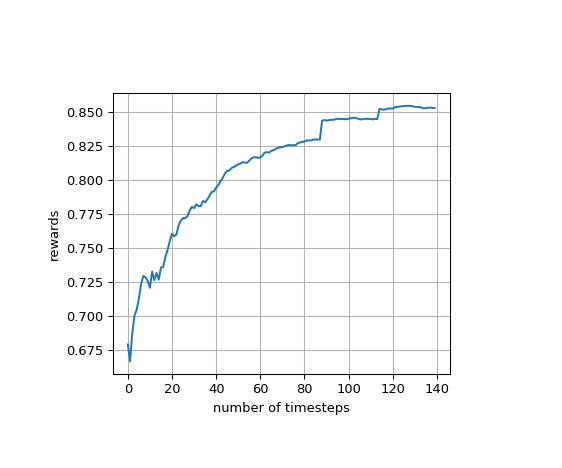

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b6c0e68d0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b6c0e6e10>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.671      |
| time/                   |            |
|    fps                  | 457        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07637861 |
|    clip_fraction        | 0.626      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.1       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0528    |
|    n_updates            | 2800       |
|    policy_gradient_loss | -0.0179    |
|    std                  | 0.132      |
|    value_loss           | 0.00111    |
---------------------------------

policy iteration runtime: 35 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.726       |
| time/                   |             |
|    fps                  | 469         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.043623336 |
|    clip_fraction        | 0.498       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.04        |
|    explained_variance   | 0.955       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0403     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0475     |
|    std                  | 

policy iteration runtime: 27 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.731     |
| time/                   |           |
|    fps                  | 463       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0551486 |
|    clip_fraction        | 0.51      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.24      |
|    explained_variance   | 0.964     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0647   |
|    n_updates            | 320       |
|    policy_gradient_loss | -0.0444   |
|    std                  | 0.18      |
|    value_loss           | 0.0014    |
--------

policy iteration runtime: 30 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.745       |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.056733884 |
|    clip_fraction        | 0.546       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.67        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0635     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0432     |
|    std                  |

policy iteration runtime: 28 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.756     |
| time/                   |           |
|    fps                  | 475       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0666964 |
|    clip_fraction        | 0.57      |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.97      |
|    explained_variance   | 0.973     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0621   |
|    n_updates            | 640       |
|    policy_gradient_loss | -0.0435   |
|    std                  | 0.174     |
|    value_loss          

policy iteration runtime: 31 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.77       |
| time/                   |            |
|    fps                  | 461        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07357506 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.38       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0834    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0399    |
|    std                  | 0.171      |
|    

policy iteration runtime: 28 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.791     |
| time/                   |           |
|    fps                  | 471       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0922491 |
|    clip_fraction        | 0.594     |
|    clip_range           | 0.15      |
|    entropy_loss         | 7.88      |
|    explained_variance   | 0.976     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0583   |
|    n_updates            | 960       |
|    policy_gradient_loss | -0.0338   |
|    std                  | 0.167     |
|    value_loss          

policy iteration runtime: 26 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.812       |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083682366 |
|    clip_fraction        | 0.614       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.58        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0335     |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.0345     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.825      |
| time/                   |            |
|    fps                  | 477        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07787631 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.4        |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00189   |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0234    |
|    std                  | 0.156      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.829       |
| time/                   |             |
|    fps                  | 487         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.090517186 |
|    clip_fraction        | 0.603       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.986       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0208     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0181     |
|    std                  |

policy iteration runtime: 26 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 484        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09132691 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0557     |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0149    |
|    std                  | 0.146      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.833       |
| time/                   |             |
|    fps                  | 487         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.086456716 |
|    clip_fraction        | 0.622       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.4        |
|    explained_variance   | 0.99        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0332     |
|    n_updates            | 1760        |
|    policy_gradient_loss | -0.0134     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b9463e8d0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b92a0cd30>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 370        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11325834 |
|    clip_fraction        | 0.621      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.6       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00588    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0177    |
|    std                  | 0.141      |
|    value_loss           | 0.000622   |
---------------------------------

policy iteration runtime: 27 seconds

Total episode rollouts: 50176

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.846     |
| time/                   |           |
|    fps                  | 395       |
|    iterations           | 1         |
|    time_elapsed         | 6         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0945799 |
|    clip_fraction        | 0.636     |
|    clip_range           | 0.15      |
|    entropy_loss         | 12.1      |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0711   |
|    n_updates            | 1960      |
|    policy_gradient_loss | -0.0209   |
|    std                  | 0.137     |
|    value_loss          

policy iteration runtime: 27 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 403        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10364065 |
|    clip_fraction        | 0.627      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.4       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.023      |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0196    |
|    std                  | 0.136      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.848       |
| time/                   |             |
|    fps                  | 388         |
|    iterations           | 1           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.087739944 |
|    clip_fraction        | 0.634       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.8        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0258     |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0168     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b4c2d7748> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b4c216860>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.855      |
| time/                   |            |
|    fps                  | 223        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11141207 |
|    clip_fraction        | 0.63       |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0154    |
|    n_updates            | 2320       |
|    policy_gradient_loss | -0.0189    |
|    std                  | 0.133      |
|    value_loss           | 0.000759   |
---------------------------------

policy iteration runtime: 34 seconds

Total episode rollouts: 63488

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.856     |
| time/                   |           |
|    fps                  | 226       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0992937 |
|    clip_fraction        | 0.635     |
|    clip_range           | 0.15      |
|    entropy_loss         | 13.1      |
|    explained_variance   | 0.983     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.067    |
|    n_updates            | 2480      |
|    policy_gradient_loss | -0.0179   |
|    std                  | 0.132     |
|    value_loss           | 0.00103   |
-------

policy iteration runtime: 38 seconds

Total episode rollouts: 67584

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.856       |
| time/                   |             |
|    fps                  | 231         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.110525474 |
|    clip_fraction        | 0.633       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.5        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0156     |
|    n_updates            | 2640        |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.129       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 71680

Eval num_timesteps=2560, episode_reward=0.86 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.857     |
| time/                   |           |
|    fps                  | 231       |
|    iterations           | 1         |
|    time_elapsed         | 11        |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1063384 |
|    clip_fraction        | 0.652     |
|    clip_range           | 0.15      |
|    entropy_loss         | 13.7      |
|    explained_variance   | 0.985     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0053    |
|    n_updates            | 2800      |
|    policy_gradient_loss | -0.0164   |
|    std                  | 0.127     |
|    value_loss           | 0.000931  |
-------

<IPython.core.display.Javascript object>


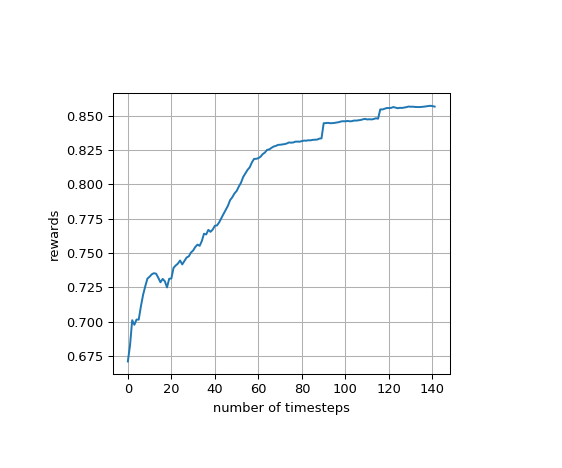

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b4c1ab470> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b4c1ab4e0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.68       |
| time/                   |            |
|    fps                  | 455        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10171328 |
|    clip_fraction        | 0.641      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.8       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0674    |
|    n_updates            | 2840       |
|    policy_gradient_loss | -0.017     |
|    std                  | 0.127      |
|    value_loss           | 0.000867   |
---------------------------------

policy iteration runtime: 29 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.719       |
| time/                   |             |
|    fps                  | 477         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.041048933 |
|    clip_fraction        | 0.485       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.9         |
|    explained_variance   | 0.96        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0689     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0463     |
|    std                  | 0.183       |
|    val

policy iteration runtime: 26 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.741      |
| time/                   |            |
|    fps                  | 452        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04647106 |
|    clip_fraction        | 0.523      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.21       |
|    explained_variance   | 0.969      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0857    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0442    |
|    std                  | 0.18       |
|    value_loss           | 

policy iteration runtime: 33 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.762     |
| time/                   |           |
|    fps                  | 471       |
|    iterations           | 1         |
|    time_elapsed         | 5         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0578928 |
|    clip_fraction        | 0.548     |
|    clip_range           | 0.15      |
|    entropy_loss         | 6.57      |
|    explained_variance   | 0.97      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0349   |
|    n_updates            | 480       |
|    policy_gradient_loss | -0.0449   |
|    std                  | 0.177     |
|    value_loss          

policy iteration runtime: 32 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 464         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.058915943 |
|    clip_fraction        | 0.574       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.02        |
|    explained_variance   | 0.974       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00935     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0415     |
|    std                  |

policy iteration runtime: 32 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.79       |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06914873 |
|    clip_fraction        | 0.578      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.64       |
|    explained_variance   | 0.976      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0381    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.0374    |
|    std                  | 0.169      |
|    

policy iteration runtime: 27 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.799       |
| time/                   |             |
|    fps                  | 471         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.070667684 |
|    clip_fraction        | 0.593       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.38        |
|    explained_variance   | 0.973       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0254     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0338     |
|    std                  |

policy iteration runtime: 25 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.807      |
| time/                   |            |
|    fps                  | 469        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08583589 |
|    clip_fraction        | 0.607      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.97       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0376    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0335    |
|    std                  | 0.159      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.813      |
| time/                   |            |
|    fps                  | 461        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07361041 |
|    clip_fraction        | 0.613      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.64       |
|    explained_variance   | 0.98       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0646    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.154      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.818       |
| time/                   |             |
|    fps                  | 477         |
|    iterations           | 1           |
|    time_elapsed         | 5           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.089062504 |
|    clip_fraction        | 0.611       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0416     |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.0232     |
|    std                  |

policy iteration runtime: 32 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.821      |
| time/                   |            |
|    fps                  | 465        |
|    iterations           | 1          |
|    time_elapsed         | 5          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08019618 |
|    clip_fraction        | 0.617      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.9       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0501    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0211    |
|    std                  | 0.146      |
|    

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b4c21ea58> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b94608e10>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 355        |
|    iterations           | 1          |
|    time_elapsed         | 7          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08969821 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11         |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00949   |
|    n_updates            | 1640       |
|    policy_gradient_loss | -0.0236    |
|    std                  | 0.145      |
|    value_loss           | 0.000701   |
---------------------------------

policy iteration runtime: 33 seconds

Total episode rollouts: 46080

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.837      |
| time/                   |            |
|    fps                  | 391        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09643123 |
|    clip_fraction        | 0.615      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.4       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0057    |
|    n_updates            | 1800       |
|    policy_gradient_loss | -0.0252    |
|    std                  | 0.143      |
|    value_loss           |

policy iteration runtime: 28 seconds

Total episode rollouts: 50176

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 388        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10714207 |
|    clip_fraction        | 0.626      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.9       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0543     |
|    n_updates            | 1960       |
|    policy_gradient_loss | -0.0225    |
|    std                  | 0.139      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.841      |
| time/                   |            |
|    fps                  | 373        |
|    iterations           | 1          |
|    time_elapsed         | 6          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10873814 |
|    clip_fraction        | 0.624      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0521    |
|    n_updates            | 2120       |
|    policy_gradient_loss | -0.0185    |
|    std                  | 0.137      |
|    

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f5b4c16d5f8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f5b4c165b38>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.849      |
| time/                   |            |
|    fps                  | 228        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10014322 |
|    clip_fraction        | 0.631      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.3       |
|    explained_variance   | 0.987      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0251    |
|    n_updates            | 2160       |
|    policy_gradient_loss | -0.0216    |
|    std                  | 0.137      |
|    value_loss           | 0.000743   |
---------------------------------

policy iteration runtime: 31 seconds

Total episode rollouts: 59392

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.851      |
| time/                   |            |
|    fps                  | 232        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11143454 |
|    clip_fraction        | 0.636      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.8       |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.028     |
|    n_updates            | 2320       |
|    policy_gradient_loss | -0.0213    |
|    std                  | 0.134      |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 63488

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.851       |
| time/                   |             |
|    fps                  | 232         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.115768865 |
|    clip_fraction        | 0.63        |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.1        |
|    explained_variance   | 0.981       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0282     |
|    n_updates            | 2480        |
|    policy_gradient_loss | -0.0224     |
|    std                  | 0.132       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 67584

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.852      |
| time/                   |            |
|    fps                  | 229        |
|    iterations           | 1          |
|    time_elapsed         | 11         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13005471 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.5       |
|    explained_variance   | 0.982      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.003      |
|    n_updates            | 2640       |
|    policy_gradient_loss | -0.0232    |
|    std                  | 0.13       |
|    value_loss           |

<IPython.core.display.Javascript object>


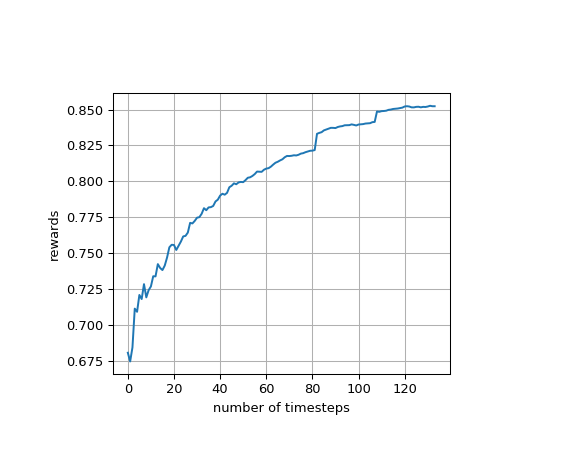

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=25,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[50000, 50000, 50000], 
                                log_dir=log_dir,
                                seed=seed)